## Settings

In [1]:
import sys
import os

sys.path.insert(0, "/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/")
sys.path.insert(0, "/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/CosmoDC2+RedMaPPer")

#NumCosmo
from numcosmo_py import Ncm, Nc, GObject
from richness_mass_calib import create_richness_mass_calib

#Functions
#from Configs_Ascaso_Ext_Analysis import Binningf

#Useful packages
import numpy as np
import math
from scipy import stats

from astropy.io import fits
from astropy.table import Table
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error

import matplotlib.pyplot as plt
import matplotlib.pyplot as gridspec
from matplotlib.gridspec import GridSpec

%matplotlib inline

Ncm.cfg_init()
Ncm.cfg_set_log_handler(lambda msg: sys.stdout.write(msg) and sys.stdout.flush())


sys.path.insert(0, "/global/homes/c/cinlima/gcr-catalogs")
import GCRCatalogs

sys.path.insert(0, "global/homes/c/cinlima/clevar/clevar")

#Put nerc if using nersc
GCRCatalogs.set_root_dir_by_site("nersc")


## Data

In [3]:
# DC2 data
test_matchdata = pd.read_csv('/global/homes/c/cinlima/match_catalog.csv',  sep = ';')

rich_data = test_matchdata["richness"]
z_data = test_matchdata["redshift_x"]
mass_data = test_matchdata["halo_mass"]

test_dt = Table([mass_data, rich_data, z_data], names=('m200c', 'richness', 'redshift_true'))

dt_halos = test_dt

lnM = np.log(dt_halos["m200c"])  # ln(mass)
z = dt_halos["redshift_true"]  # redshift
lnR = np.log(dt_halos["richness"])  # ln(richness)

dth = dt_halos.to_pandas().sort_values(['m200c','redshift_true'], ignore_index=True)

## Training and test sets

In [30]:
X = pd.DataFrame({'m200c': list(dth["m200c"]), 'redshift_true': list(dth["redshift_true"])})
y = pd.DataFrame({'richness': list(dth["richness"])})

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

#Training data
data_train = pd.concat([X_train, y_train], axis=1)

#Test  data
data_test = pd.concat([X_test, y_test], axis=1)

# print( data_test.shape, X_test.shape, y_test.shape )
# print( data_train.shape, X_train.shape, y_train.shape )

# print( data_test.shape[0] + data_train.shape[0] )

# print( len(dt_halos) )

## Bins

Nestas células fazemos um recorte de intervalos de z de largura 0.05 e esses intervalos são colocados em **halos_bin_z**. Depois, pegamos cada *bin* em z e cortamos em intervalos de lnM de largura 0.25. Os bins são colocados em **halos_bin_mz**.

Para cada intervalo em **halos_bin_mz** é calculado lnR médio, z médio e lnM médio e as listas desses valores são colocadas na tabela **halos_mean**.

In [31]:
def Binningf(dth):
    halos_bin = []
    a=0
    for i in range(len(dth)//10):
        halos_bin.append(dth.iloc[a: a + 9])
    
        a = a + 10
    return halos_bin

print(f'Total bins in halos_bin: {len(Binningf(dth))}')

Total bins in halos_bin: 3960


In [33]:
def bin_meanf(data_set):
    lnM_binned, z_binned, lnR_binned = [], [], [] 

    binned_halos = Binningf(data_set)

    for i in range(len(binned_halos)):

        halos = binned_halos[i]
        lnM_binned.append(np.log(halos["m200c"]))
        z_binned.append(halos["redshift_true"])
        lnR_binned.append(np.log(halos["richness"]))   

    lnR_mean, lnM_mean, z_mean = [np.mean(l) for l in lnR_binned if len(l) > 0], [np.mean(l) for l in lnM_binned if len(l) > 0], [np.mean(k) for k in z_binned if len(k) > 0]
    
    lnR_std = np.array([np.std(l) for l in lnR_binned if len(l) > 0])

    
    halos_mean = Table([np.exp(np.array(lnR_mean)), np.exp(np.array(lnM_mean)), z_mean],
               names=('richness', 'm200c', 'redshift_true'))
    
    return halos_mean, lnM_binned, z_binned, lnR_binned, lnR_std

print(f'Total bins in halos_mean: {len(bin_meanf(dth)[0])}')


Total bins in halos_mean: 3960


## Models fit

In [36]:
def Model_fit(mod, data_set):
    
    #data_set
    # dt_halos = Table(DC2_halos_m200c[1].data)
    rmdata = create_richness_mass_calib(data_set)
    
    fixed_parameters = [] 
    
    #Swicth
    match mod:
        case "ext_ln1pz":
            model = Nc.ClusterMassLnrichExt(use_ln1pz = True)
            fixed_parameters = [12, 13, 14] #fixing cut parameters
            
        case "ext_z":
            model = Nc.ClusterMassLnrichExt(use_ln1pz = False)
            fixed_parameters = [12, 13, 14] #fixing cut parameters
            
        case "ascaso":
            model = Nc.ClusterMassAscaso()
            fixed_parameters = [6] #fixing cut parameter
    
    #Model
    model.param_set_by_name("cut", 1e15) #Set cut parameter value 
    mset = Ncm.MSet()
    mset.set(model)
    rmdata.m2lnL_val(mset)  
    mset.param_set_all_ftype(Ncm.ParamType.FREE) #All parameters free
    
    #Data
    dset = Ncm.Dataset.new()
    dset.append_data(rmdata)
    
    #Likelihood
    lh = Ncm.Likelihood.new(dset)
  
    #All parameters free except cut parameters:
    for par in fixed_parameters:
        mset.param_set_ftype(7000, par, Ncm.ParamType.FIXED)
    
    mset.prepare_fparam_map()
    
    #Fit
    fit = Ncm.Fit.factory( Ncm.FitType.NLOPT, "ln-neldermead", lh, mset, Ncm.FitGradType.NUMDIFF_CENTRAL )
    fit.log_info()
    fit.run_restart(Ncm.FitRunMsgs.SIMPLE, 1.0e-3, 0.0, None, None)
    fit.log_info()
    
    #Binning data_set
    bin_f= bin_meanf(data_set)
    halos_mean = bin_f[0]
    lnM_mean = np.log(halos_mean["m200c"])
    z_mean = halos_mean["redshift_true"]
    
    # Mean and std of data_set z mean and lnM mean
    lnR_mean_model = np.array([model.get_mean_richness(lnM_mean[i], z_mean[i]) for i in range(len(halos_mean))])
    lnR_std_model = np.array( [model.get_std_richness(lnM_mean[i], z_mean[i]) for i in range(len(halos_mean))])
    
    return lnR_mean_model, lnR_std_model, model



## Ascaso Fit Params

Aqui fazemos o ajuste do modelo de ascaso e encontramos os valores dos parâmetros usando todos os dados em **dt_halos** (sem dividir em intervalos). 

\begin{equation}
    \left< \ln R | M, z \right> = \mu_0 + \mu_1 \ln\left( \frac{M}{M_0} \right) +  \mu_2\ln\left(\frac{1 + z}{1 + z_0}\right);
\end{equation}

$$\textbf{p}_{1} = \{\mu_0, \mu_1, \mu_2, \sigma_0, \sigma_1, \sigma_2\}. $$



In [37]:
lnR_mean_ascaso, lnR_std_ascaso, ascaso = Model_fit('ascaso', data_train)

#----------------------------------------------------------------------------------
# Data used:
#   - NcDataClusterMassRich
#----------------------------------------------------------------------------------
# Model[07000]:
#   - NcClusterMass : Ascaso Ln-normal richness distribution
#----------------------------------------------------------------------------------
# Model parameters
#   -    mup0[00]:  3.19                [FREE]
#   -    mup1[01]:  0.868588963806504   [FREE]
#   -    mup2[02]: -0.304006137332276   [FREE]
#   - sigmap0[03]:  0.33                [FREE]
#   - sigmap1[04]: -0.0347435585522601  [FREE]
#   - sigmap2[05]:  0                   [FREE]
#   -     cut[06]:  1e+15               [FIXED]
#----------------------------------------------------------------------------------
# Model fitting. Interating using:
#  - solver:            NLOpt:ln-neldermead
#  - differentiation:   Numerical differentiantion (central)
#........................................................

## Ext (ln(1+z)) Fit Params

Aqui fazemos o ajuste do modelo extendido considerando a dependencia em $\ln (1 + z)$, também usando todos os dados em **dt_halos** .

\begin{equation}\label{M_R_3}
\begin{split}
    \left<\ln R | M, z \right> = \mu_0 + 
    \mu_{M1} \ln\left( \frac{M}{M_0} \right) +
    \mu_{M2} (\ln\left(\frac{M}{M_0} \right))^2 +\\
    + \mu_{z1} \ln\left(\frac{1 + z}{1 + z_0}\right) +
    \mu_{z2} (\ln\left(\frac{1 + z}{1 + z_0}\right))^2 +\\
    + \mu_{Mz} \ln\left(\frac{1 + z}{1 + z_0}\right)\ln\left(\frac{M}{M_0} \right);
\end{split}
\end{equation}

$$\textbf{p}_{2} = \{\mu_0, \mu_{M1}, \mu_{M2}, \mu_{Z1}, \mu_{Z2}, \mu_{MZ}, \sigma_0, \sigma_{M1}, \sigma_{M2}, \sigma_{Z1}, \sigma_{Z2}, \sigma_{MZ} \}.$$

In [38]:
lnR_mean_ext_ln1pz, lnR_std_ext_ln1pz, ext_ln1pz = Model_fit('ext_ln1pz', data_train)

#----------------------------------------------------------------------------------
# Data used:
#   - NcDataClusterMassRich
#----------------------------------------------------------------------------------
# Model[07000]:
#   - NcClusterMass : LnrichExt Ln-normal richness distribution
#----------------------------------------------------------------------------------
# Model parameters
#   -      mu[00]:  3.19                [FREE]
#   -    muM1[01]:  0.868588963806504   [FREE]
#   -    muZ1[02]: -0.304006137332276   [FREE]
#   -    muM2[03]:  0                   [FREE]
#   -    muZ2[04]:  0                   [FREE]
#   -    muMZ[05]:  0                   [FREE]
#   -  sigma0[06]:  0.33                [FREE]
#   - sigmaM1[07]: -0.0347435585522601  [FREE]
#   - sigmaZ1[08]:  0                   [FREE]
#   - sigmaM2[09]:  0                   [FREE]
#   - sigmaZ2[10]:  0                   [FREE]
#   - sigmaMZ[11]:  0                   [FREE]
#   -      A0[12]:  0                   [FIX

## Ext (z) Fit Params


Aqui consideramos o ajuste do modelo extendido considerando a dependência em $ z$, também usando todos os dados em **dt_halos** .

\begin{equation}\label{M_R_3}
\begin{split}
    \left<\ln R | M, z \right> = \mu_0 + 
    \mu_{M1} \ln\left( \frac{M}{M_0} \right) +
    \mu_{M2} (\ln\left(\frac{M}{M_0} \right))^2 +\\
    + \mu_{z1} \left(\frac{ z}{z_0}\right) +
    \mu_{z2} \left(\frac{z}{z_0}\right)^2 +
    \mu_{Mz} \left(\frac{z}{z_0}\right)\ln\left(\frac{M}{M_0} \right);
\end{split}
\end{equation}

$$\textbf{p}_{2} = \{\mu_0, \mu_{M1}, \mu_{M2}, \mu_{Z1}, \mu_{Z2}, \mu_{MZ}, \sigma_0, \sigma_{M1}, \sigma_{M2}, \sigma_{Z1}, \sigma_{Z2}, \sigma_{MZ} \}.$$

In [39]:
lnR_mean_ext_z, lnR_std_ext_z, ext_z = Model_fit('ext_z', data_train)

#----------------------------------------------------------------------------------
# Data used:
#   - NcDataClusterMassRich
#----------------------------------------------------------------------------------
# Model[07000]:
#   - NcClusterMass : LnrichExt Ln-normal richness distribution
#----------------------------------------------------------------------------------
# Model parameters
#   -      mu[00]:  3.19                [FREE]
#   -    muM1[01]:  0.868588963806504   [FREE]
#   -    muZ1[02]: -0.304006137332276   [FREE]
#   -    muM2[03]:  0                   [FREE]
#   -    muZ2[04]:  0                   [FREE]
#   -    muMZ[05]:  0                   [FREE]
#   -  sigma0[06]:  0.33                [FREE]
#   - sigmaM1[07]: -0.0347435585522601  [FREE]
#   - sigmaZ1[08]:  0                   [FREE]
#   - sigmaM2[09]:  0                   [FREE]
#   - sigmaZ2[10]:  0                   [FREE]
#   - sigmaMZ[11]:  0                   [FREE]
#   -      A0[12]:  0                   [FIX

## Comparison I

In [55]:
def Plot_model(model, data_set, mean):

    fig = plt.figure(figsize=(16,4))
#     gs = gridspec.GridSpec(nrows=2, ncols=2, width_ratios=[1, 1], height_ratios=[2.5, 1], wspace=0.4)
    
#     ax1 = fig.add_subplot(gs[0, :], projection='3d')
#     ax2 = fig.add_subplot(gs[1, 0])
#     ax3 = fig.add_subplot(gs[1, 1])
    ax1 = fig.add_subplot(1,3,1, projection='3d')
    ax2 = fig.add_subplot(1,3,2)
    ax3 = fig.add_subplot(1,3,3)

    #Mu plot config ---------------------------------------
    if mean == True:
        #lnR model, z_mean, y_mean
        halos_mean = bin_meanf(data_set)[0]
        lnR_mean = np.log(halos_mean["richness"])

        xs = halos_mean["redshift_true"]
        ys = np.log(halos_mean["m200c"])
        zs = model

        lb_model = '<$Ln\lambda$| M, z>'
        lb_binned = '$\ln \lambda_i$ médio'
        m = lnR_mean
                
        if f'{model}' == f'{lnR_mean_ascaso}': 
            fig.suptitle('Modelo de Ascaso')
        elif f'{model}' == f'{lnR_mean_ext_ln1pz}': 
            fig.suptitle('Modelo Estendido (ln(1 + z))')
        elif f'{model}' == f'{lnR_mean_ext_z}': 
            fig.suptitle('Modelo Estendido (z)')
        else: 
            pass
    
    #Std plot config ---------------------------------------
    else:
        halos_mean = bin_meanf(data_set)[0]
        std_mean = bin_meanf(data_set)[4]
    
        xs = halos_mean["redshift_true"]
        ys = np.log(halos_mean["m200c"])
        zs = model 
        
        lb_model = '$\sigma_{\ln \lambda}$'
        lb_binned = '$\sigma^{i}$'
        m = std_mean
                
        if f'{model}' == f'{lnR_std_ascaso}': 
            fig.suptitle('Modelo de Ascaso', size=16)
        elif f'{model}' == f'{lnR_std_ext_ln1pz}': 
            fig.suptitle('Modelo Estendido (ln(1 + z))', size=16)
        elif f'{model}' == f'{lnR_std_ext_z}': 
            fig.suptitle('Modelo Estendido (z)', size=16)
        else: 
            pass
        
    #-------------------------------------------------------
    p1 =ax1.scatter(xs, ys, zs, c=zs, cmap='cool')
    ax1.set_xlabel('z')
    ax1.set_ylabel('lnM')
    fig.colorbar(p1, ax=ax1, label= lb_model)

    ax2.scatter(ys, m, c='k', s=2.0, label=lb_binned)
    p2 = ax2.scatter(ys, zs , c= xs, s=2.0, cmap='cool')
    ax2.set_xlabel('lnM')
    ax2.set_ylabel(lb_model)
    fig.colorbar(p2, ax=ax2, label='z')
    ax2.legend()

    ax3.scatter(xs, m, c='k', s=2.0, label=lb_binned)
    p3 = ax3.scatter(xs, zs , c=ys, s=2.0, cmap='cool') 
    ax3.set_xlabel('z')
    ax3.set_ylabel(lb_model)
    fig.colorbar(p3, ax=ax3, label='lnM')
    ax3.legend()         
    plt.show()


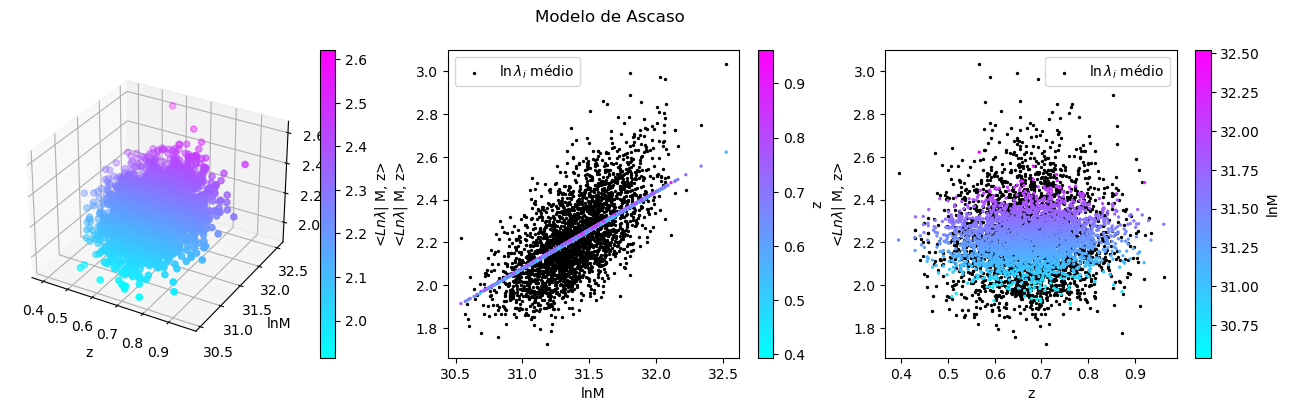

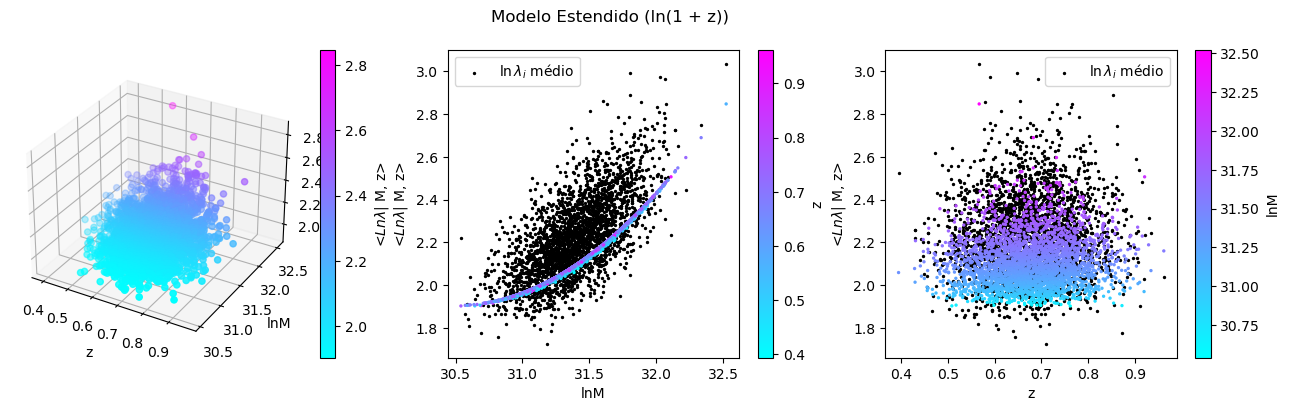

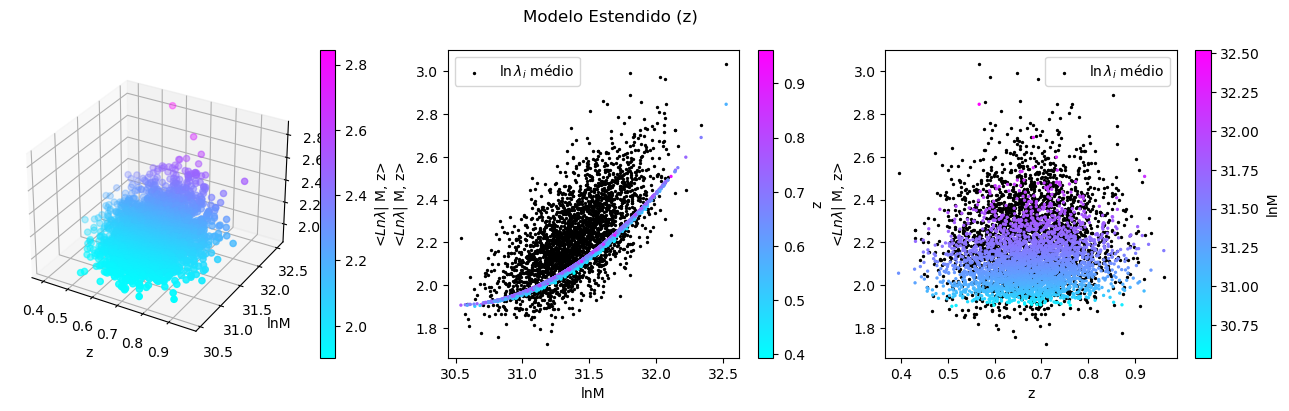

In [56]:
Plot_model(lnR_mean_ascaso, data_train, mean = True) #Ascaso
Plot_model(lnR_mean_ext_ln1pz, data_train, mean = True) #Extended (ln(1 + z)) 
Plot_model(lnR_mean_ext_z, data_train, mean = True)

plt.show()

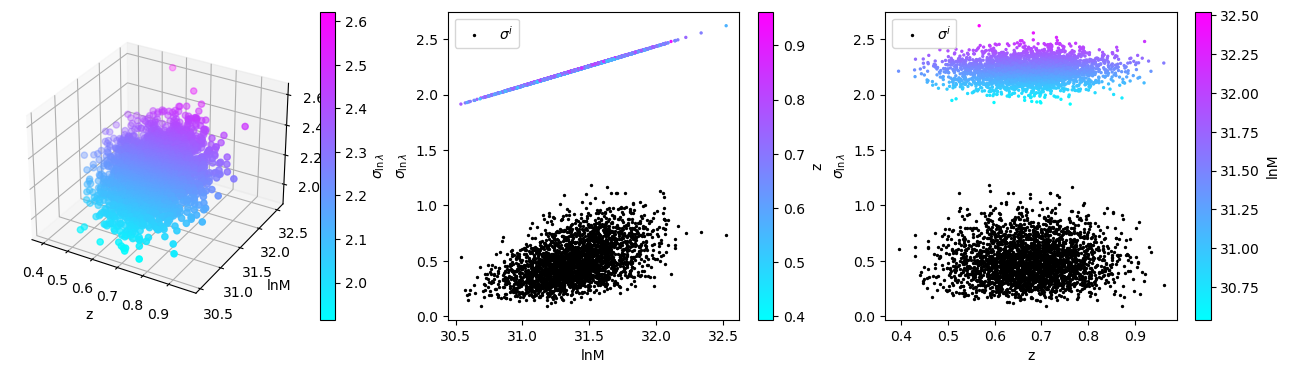

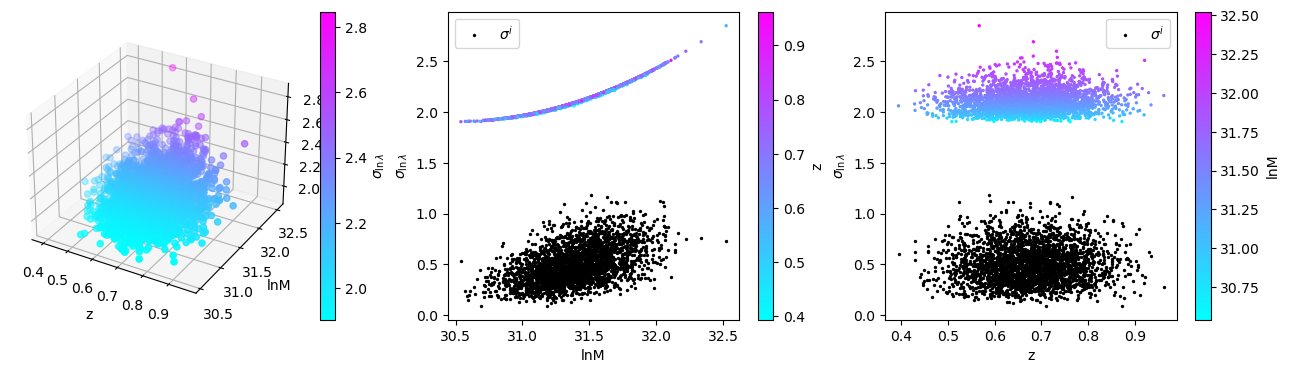

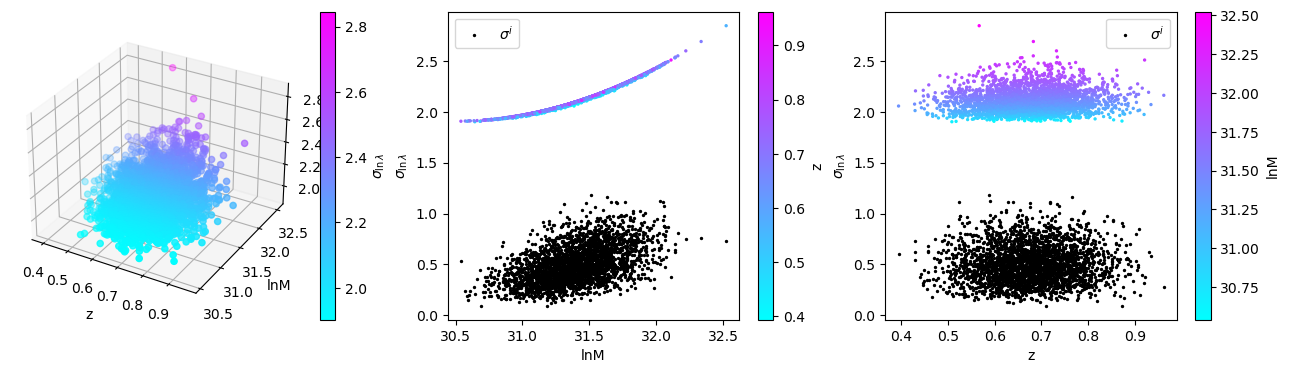

In [58]:
Plot_model(lnR_mean_ascaso, data_train, mean = False) #Ascaso
Plot_model(lnR_mean_ext_ln1pz, data_train, mean = False) #Extended (ln(1 + z)) 
Plot_model(lnR_mean_ext_z, data_train, mean = False)

plt.show()